# Logistic Regression on  Amazon Finefood Reviews.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

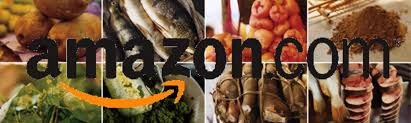

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

    Id
    ProductId - unique identifier for the product
    UserId - unqiue identifier for the user
    ProfileName
    HelpfulnessNumerator - number of users who found the review helpful
    HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    Score - rating between 1 and 5
    Time - timestamp for the review
    Summary - brief summary of the review
    Text - text of the review

Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Summary

    1. Applied Logistic Regression on Amazon Fine Foods Text Reviews.
    2. Used different text proecssing techniques like Bag of Words, Tf-Idf, Average Word to Vector and Tf-Idf weighted 
       Word to Vector.
    3. Used Gird Search and Random Search technique to find the optimal parameters for Logistic Regression.
    4. Did sparsity check by applying L1 regularization, as 'C' value increases the sparcity of vector decreases.
    5. Used F1 as scoring metric since the data is imbalanced.
    6. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall.
    7. Did multicollinearity check by performing Perturbation test.
    8. Obtained the Top 10 Positive and Negative words.

## Objective 

 To determinne the polarity of a Text Review. 
    

In [2]:
#Importing all the necessary packages.
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [3]:
# Now accesing the database where we have cleaned text. Cleaned Text means, the transformed text which has been Lemmatized, 
#Stemmed,etc. 
conn = sqlite3.connect('C:/Users/Swaroop/Desktop/Srikanth Reddy/final1.sqlite')
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn) 

In [4]:
#Converting the Unix time stamp to human readable form.
final['Time']=(pd.to_datetime(final['Time'],unit='ms')) 

In [5]:
#Here we can see that we have almost3.65lakh reviews.
final.shape

(364171, 12)

In [6]:
# Sorting the reviews accoring to Time stamp in ascending order so that old reviews remain in train and the latest reviews in test.
final2=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
(final2).shape #Taking alll the 3.4lakhs rows.

(364171, 12)

In [8]:
# Checking if data is imbalanced.
final2['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
#Importing all the necessary packages for performing Knn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# Part I
# ============================== Data Preprocessing ===========================================
#Here we will be performing Logistic Regression on only reviews, thats why we take only CleanedText column in X.
#In variable 'y', we keep only Scores(positive,negative) for a the corresponding reviews. 
X = final2.CleanedText.values # end index is exclusive
y = final2.Score.values # showing you two ways of indexing a pandas df
X.shape # We can see that there are 3.6 lakh reviews(rows)

(364171,)

In [11]:
# Splitting the data in train and test where we have 80% od data in Train and rest in Test.
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

## Bag of Words(Unigram) Vectorizer.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2)) 
bow_lr_train = count_vect.fit_transform(X_train) # Here we fit transform the data

bow_lr_train.get_shape()# obtaining the shape

(291336, 2522924)

In [13]:
# Standardization of Data. This step is importand because sometimes the feature values could be in different scales. So standardization could solve scaling problem.
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

bow_lr_train=StandardScaler(with_mean=False).fit_transform(bow_lr_train)
bow_lr_train

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<291336x2522924 sparse matrix of type '<class 'numpy.float64'>'
	with 20058439 stored elements in Compressed Sparse Row format>

In [14]:
bow_lr_test=count_vect.transform(X_test) # Transforming the test data.
bow_lr_test.get_shape()

(72835, 2522924)

In [15]:
bow_lr_test=StandardScaler(with_mean=False).fit_transform(bow_lr_test)
bow_lr_test

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<72835x2522924 sparse matrix of type '<class 'numpy.float64'>'
	with 4624071 stored elements in Compressed Sparse Row format>

### Using GridSearchCV to find the optimal parameters.

In [17]:
# It is very important to find the optimal parameters before applying any algorithm on the data.
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer() 
y_train = np.array([number[0] for number in lb.fit_transform(y_train)]) 
y_test= np.array([number[0] for number in lb.fit_transform(y_test)])


lr = LogisticRegression(class_weight='balanced') # class_weight is set to 'balanced' because data is imbalanced. We can also give a dict of values if we want.
#params we need to try on classifier
param = {'C':[50,10,1,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], # List of 'C' values. 
             'penalty':['l1','l2']} # Both the regularization terms.
grid_lr = GridSearchCV(lr,param,cv=5,verbose=1,scoring= 'f1',n_jobs=-1) # Since all data is imbalanced, accuracy can't be used as scoring metric, so we can use metrics like precision, recall, f1 or roc_auc.
grid_lr.fit(bow_lr_train,y_train)
print("Best HyperParameter: ",grid_lr.best_params_) # We get the best C and penality.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 298.1min finished


Best HyperParameter:  {'C': 0.01, 'penalty': 'l1'}
Wall time: 4h 58min 20s


In [18]:
print("Best Accuracy: %.2f%%"%(grid_lr.best_score_*100)) 

Best Accuracy: 96.08%


Accuracy on test set: 93.106%
Precision on test set: 0.938
Recall on test set: 0.984
F1-Score on test set: 0.960


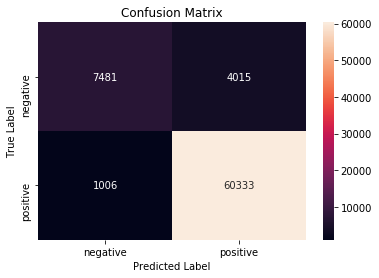

Wall time: 11.2 s


In [19]:
%%time
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)]) 
y_test= np.array([number[0] for number in lb.fit_transform(y_test)])

clf = LogisticRegression(C= 0.01, penalty= 'l1') # Using the best parameters obtained by grid search
clf.fit(bow_lr_train,y_train)
pred = clf.predict(bow_lr_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))

cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Sparsity Test on Bow

1. When we use L1 Regularizer, we get a very sparse vectors.
2. This sparsity can be observed when we change the value of 'C'.
3. As the value of 'C' is reduced, we can see an eventual increase in sparsity.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

c=[1000,50,1]
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)]) 
y_test= np.array([number[0] for number in lb.fit_transform(y_test)])

for i in c:
    clf = LogisticRegression(C= i, penalty= 'l1')
    clf.fit(bow_lr_train,y_train)
    pred = clf.predict(bow_lr_test)
    print("For C=",i)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
    print("Non Zero weights:",np.count_nonzero(clf.coef_))
    print("********************")
    print("\n")

For C= 1000
Accuracy on test set: 86.662%
F1-Score on test set: 0.922
Non Zero weights: 1842811
********************


For C= 50
Accuracy on test set: 92.473%
F1-Score on test set: 0.956
Non Zero weights: 295777
********************


For C= 1
Accuracy on test set: 92.434%
F1-Score on test set: 0.956
Non Zero weights: 230811
********************




### Using RandomSearchCV to find the optimal parameters.

It is sometimes observed that Random Search works better than Grid Search.

In [19]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
#params we need to try on classifier
param= { 'C':[50,10,1,0.1,0.05,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
rand_lr = RandomizedSearchCV(lr,param,cv=5,verbose=1, scoring='f1',n_jobs=-1)
rand_lr.fit(bow_lr_train,y_train)
print("Best HyperParameter: ",rand_lr.best_params_)
print("Best Accuracy: %.2f%%"%(rand_lr.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 98.6min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 0.005}
Best Accuracy: 96.07%
Wall time: 1h 38min 50s


Accuracy on test set: 93.038%
Precision on test set: 0.937
Recall on test set: 0.984
F1-Score on test set: 0.960


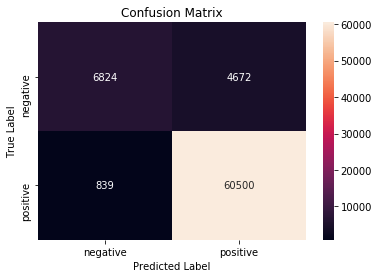

In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.005, penalty= 'l1')
clf.fit(bow_lr_train,y_train)
y_pred = clf.predict(bow_lr_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Pertubation Test

The objective of Perturbation Test is to find if the features are multicollinear or not.

1. We fit the model and calculate the weighs
2. Add a small error(epsilon=0.01 to 0.02) to the non-zero data points.
3. Now again train the model on the new weights.
4. Now find the difference between weights. If it is observed to be more then the features are multicollinear.

In [55]:
from scipy.sparse import find

bow_weight1 = find(clf.coef_[0])[2] # This will show the initial weights.
bow_weight1[0:20]

array([ 6.36526738e-04,  9.00270187e-04, -1.06076348e-07,  2.81651473e-03,
        2.76779093e-03,  1.82824244e-04,  3.08155265e-04, -1.66403141e-03,
        4.66182301e-04,  3.85006461e-04,  1.23786812e-07, -1.13551729e-06,
        1.83895262e-04,  6.58512411e-05,  3.18342687e-05,  1.33423442e-03,
        6.20338593e-05,  6.20330278e-05,  4.57033773e-05,  4.57039969e-05])

In [56]:
clf.coef_.shape

(1, 2522924)

In [57]:
bow_weight1.shape

(2522924,)

In [58]:
bow_lr_train_error = bow_lr_train
#Random noise
error = np.random.uniform(low=0.01, high=0.02, size=(find(bow_lr_train_error)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(bow_lr_train_error)

#Introducing random noise to non-zero datapoints
bow_lr_train_error[a,b] = error + bow_lr_train_error[a,b]

In [59]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.005, penalty= 'l2')
clf.fit(bow_lr_train_error,y_train)
y_pred = clf.predict(bow_lr_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
#print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.506%


In [60]:
from scipy.sparse import find
#Weights after adding random noise
bow_weight2 = find(clf.coef_[0])[2]
print(bow_weight2[:20])

[ 6.34432412e-04  9.00919727e-04 -3.71874713e-06  2.81510977e-03
  2.76655671e-03  1.81835741e-04  3.07590744e-04 -1.66334865e-03
  4.65424731e-04  3.84836690e-04  1.29521554e-07 -8.20051093e-07
  1.83067423e-04  6.55024593e-05  3.20729954e-05  1.33521932e-03
  6.21479937e-05  6.21465977e-05  4.56879691e-05  4.56890898e-05]


In [61]:
clf.coef_.shape

(1, 2522924)

In [62]:
bow_weight2.shape

(2522924,)

In [63]:
difference = (abs(bow_weight1 - bow_weight2)/bow_weight1) * 100

In [67]:
print(difference[np.where(difference > 50)].size) # Number of features whose weights changed more than 50%.

14120


In [68]:
# Obtainging the top features.
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = clf.coef_[0].argsort()
print('Top Negative Words: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top Positive Words: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Top Negative Words: 
['not buy' 'not worth' 'not recommend' 'would not' 'disappoint' 'not good'
 'wast money' 'wont buy' 'worst' 'not purchas']

Top Positive Words: 
['great' 'love' 'good' 'best' 'delici' 'excel' 'favorit' 'tast great'
 'perfect' 'dog love']



## Tf-Idf Vectorizer

In [69]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_lr_train = vect.fit_transform(X_train)
tfidf_lr_train.shape

(291336, 2522924)

In [70]:
# Standardization of Data. This step is importand because sometimes the feature values could be in different scales. So standardization could solve scaling problem.
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

tfidf_lr_train=StandardScaler(with_mean=False).fit_transform(tfidf_lr_train)
tfidf_lr_train

<291336x2522924 sparse matrix of type '<class 'numpy.float64'>'
	with 20058439 stored elements in Compressed Sparse Row format>

In [72]:
tfidf_lr_test=vect.transform(X_test)
tfidf_lr_test.get_shape()

(72835, 2522924)

In [73]:
tfidf_lr_test=StandardScaler(with_mean=False).fit_transform(tfidf_lr_test)
tfidf_lr_test

<72835x2522924 sparse matrix of type '<class 'numpy.float64'>'
	with 4624071 stored elements in Compressed Sparse Row format>

### Using GridSearchCV to find the optimal parameters.

In [75]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer() 
y_train = np.array([number[0] for number in lb.fit_transform(y_train)]) 
y_test= np.array([number[0] for number in lb.fit_transform(y_test)])


lr = LogisticRegression(class_weight='balanced') # class_weight is set to 'balanced' because data is imbalanced. We can also give a dict of values if we want.
#params we need to try on classifier
param = {'C':[50,10,1,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], # List of 'C' values. 
             'penalty':['l1','l2']} # Both the regularization terms.
grid_lr = GridSearchCV(lr,param,cv=5,verbose=1,scoring= 'f1',n_jobs=-1) # Since all data is imbalanced, accuracy can't be used as scoring metric, so we can use metrics like precision, recall, f1 or roc_auc.
grid_lr.fit(tfidf_lr_train,y_train)
print("Best HyperParameter: ",grid_lr.best_params_) # We get the best C and penality.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.3min finished


Best HyperParameter:  {'C': 0.01, 'penalty': 'l1'}
Wall time: 28min 29s


In [76]:
print("Best Accuracy: %.2f%%"%(grid_lr.best_score_*100)) 

Best Accuracy: 96.25%


Accuracy on test set: 93.369%
Precision on test set: 0.940
Recall on test set: 0.984
F1-Score on test set: 0.962


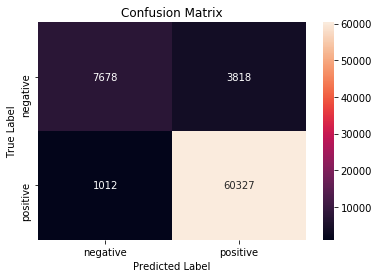

Wall time: 11.3 s


In [80]:
%%time
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)]) 
y_test= np.array([number[0] for number in lb.fit_transform(y_test)])

clf = LogisticRegression(C= 0.01, penalty= 'l1') # Using the best parameters obtained by grid search
clf.fit(tfidf_lr_train,y_train)
pred = clf.predict(tfidf_lr_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))

cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [123]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
#params we need to try on classifier
param= { 'C':[50,10,1,0.1,0.05,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
rand_lr = RandomizedSearchCV(lr,param,cv=5,verbose=1, scoring='f1',n_jobs=-1)
rand_lr.fit(tfidf_lr_train,y_train)
print("Best HyperParameter: ",rand_lr.best_params_)
print("Best Accuracy: %.2f%%"%(rand_lr.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.6min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 96.22%
Wall time: 11min 44s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Accuracy on test set: 90.702%
Precision on test set: 0.906
Recall on test set: 0.993
F1-Score on test set: 0.947


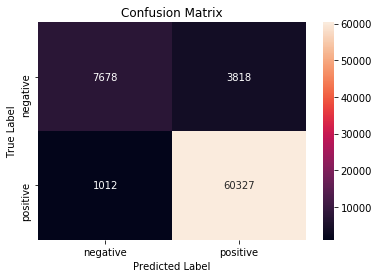

In [165]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l2',class_weight='balanced',n_jobs=-1)
clf.fit(tfidf_lr_train,y_train)
y_pred = clf.predict(tfidf_lr_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Pertubation Test

The objective of Perturbation Test is to find if the features are multicollinear or not.

In [166]:
from scipy.sparse import find

tfidf_weight1 = find(clf.coef_[0])[2] # This will show the initial weights.
tfidf_weight1[0:20]

array([ 1.42839148e-03,  1.44699179e-03, -2.34004514e-05,  5.77574989e-03,
        6.01908044e-03,  5.10715290e-04,  8.88886231e-04, -2.26400671e-03,
        8.37724506e-04,  6.10094841e-04, -3.15252739e-04,  9.99210298e-06,
        4.95654000e-04,  3.13976730e-04,  2.80126928e-04,  1.63606670e-03,
        2.61090348e-04,  2.61089416e-04,  1.20029174e-04,  1.20027306e-04])

In [167]:
find(clf.coef_[0])[2]

array([ 1.42839148e-03,  1.44699179e-03, -2.34004514e-05, ...,
        1.07936706e-03,  4.26444061e-04,  4.26444626e-04])

In [168]:
tfidf_weight1.shape

(2522924,)

In [169]:
tfidf_lr_train_error = tfidf_lr_train
#Random noise
error = np.random.uniform(low=0.01, high=0.02, size=(find(tfidf_lr_train_error)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(tfidf_lr_train_error)

#Introducing random noise to non-zero datapoints
tfidf_lr_train_error[a,b] = error + tfidf_lr_train_error[a,b]

In [172]:
%%time
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(C= 1, penalty= 'l2',n_jobs=-1)
clf1.fit(tfidf_lr_train_error,y_train)
y_pred = clf1.predict(tfidf_lr_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
#print("Non Zero weights:",np.count_nonzero(clf.coef_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Accuracy on test set: 90.266%
Wall time: 1min 42s


In [173]:
from scipy.sparse import find
#Weights after adding random noise
tfidf_weight2 = find(clf1.coef_[0])[2]
print(tfidf_weight2[:20])

[ 1.44977120e-03  1.46586401e-03 -4.64562980e-06  6.12610634e-03
  6.48162420e-03  4.71162851e-04  9.23914183e-04 -2.32186685e-03
  8.32494119e-04  6.51480978e-04 -2.33560371e-04  1.51292141e-05
  4.49369501e-04  2.55822694e-04  3.42214379e-04  1.65379727e-03
  2.27062633e-04  2.27063230e-04  1.77329848e-04  1.77327554e-04]


In [174]:
tfidf_weight2.shape

(2522924,)

In [175]:
difference = (abs(tfidf_weight1 - tfidf_weight2)/tfidf_weight1) * 100

In [176]:
print(difference[np.where(difference > 50)].size) # Number of features whose weights changed more than 50%.

252277
